In [7]:
!pip install tqdm
!pip install google_images_download
!pip install torch
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 4.1 MB/s eta 0:00:00a 0:00:01


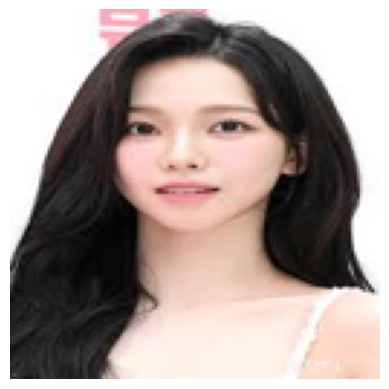

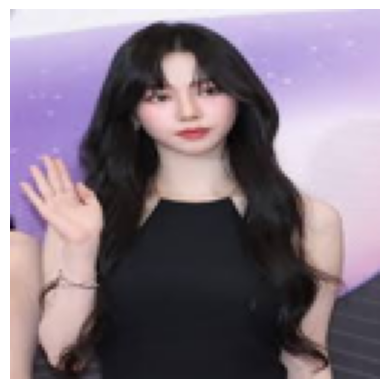

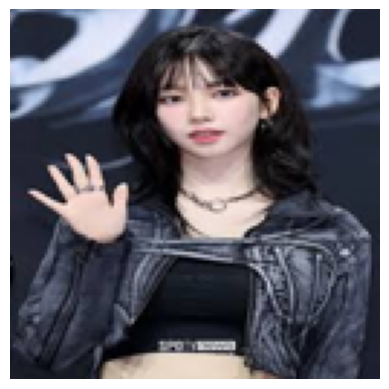

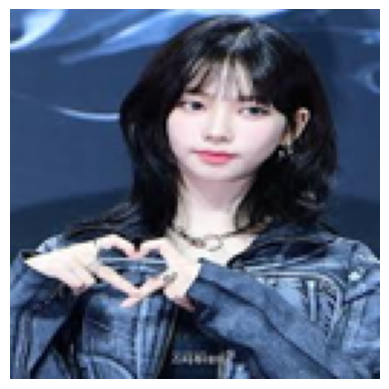

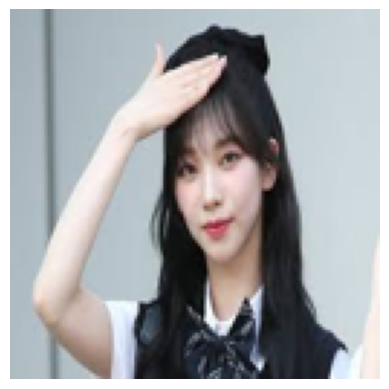

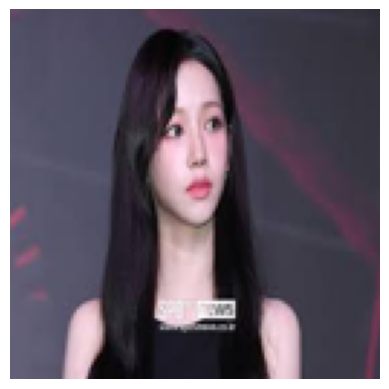

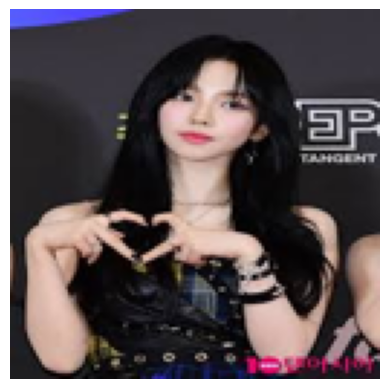

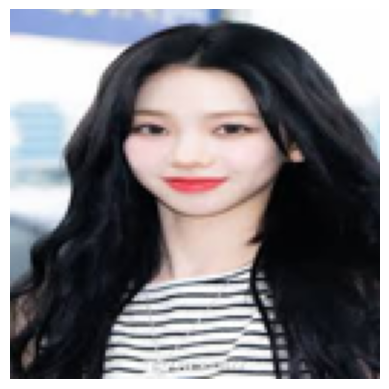

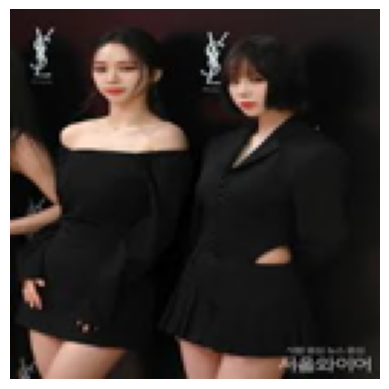

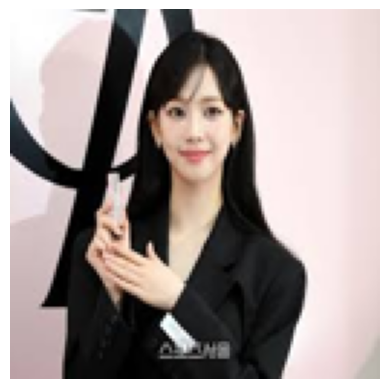

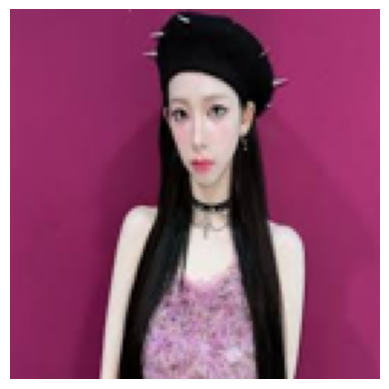

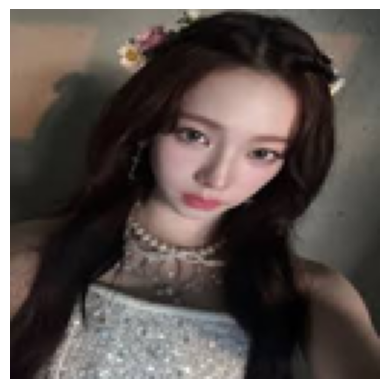

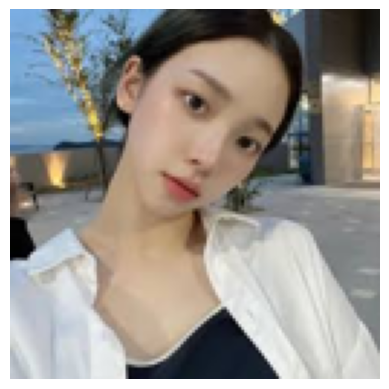

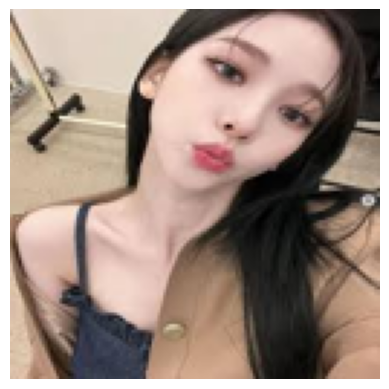

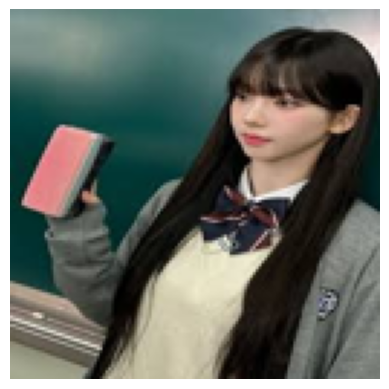

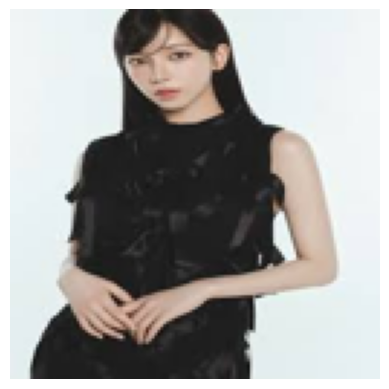

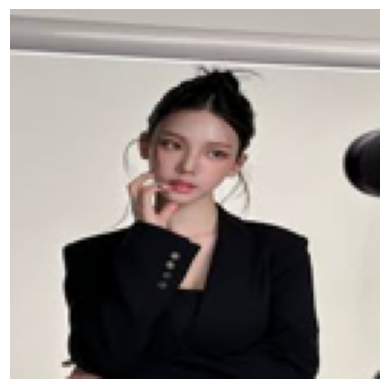

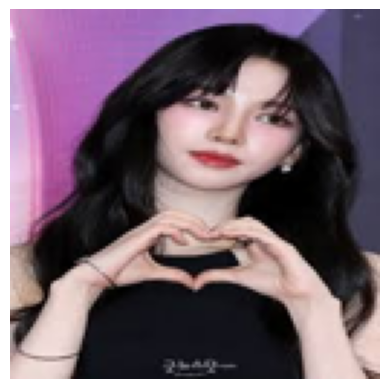

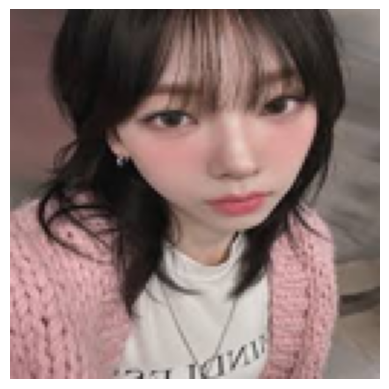

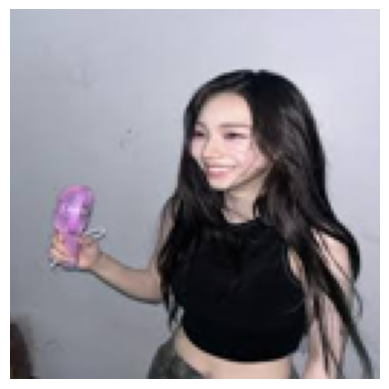

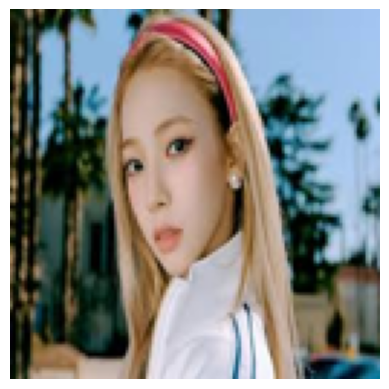

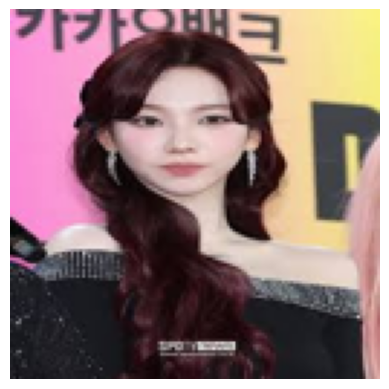

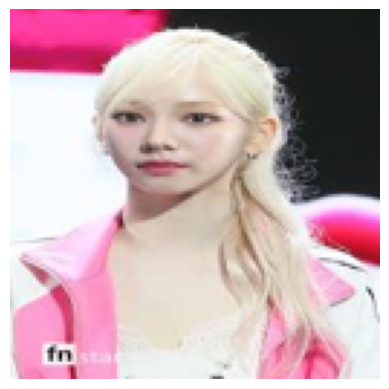

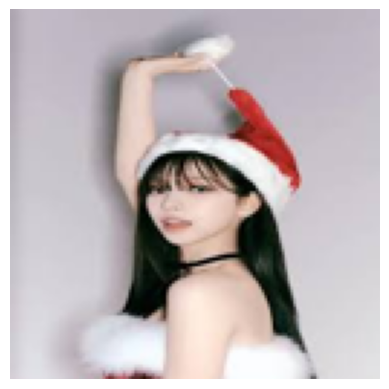

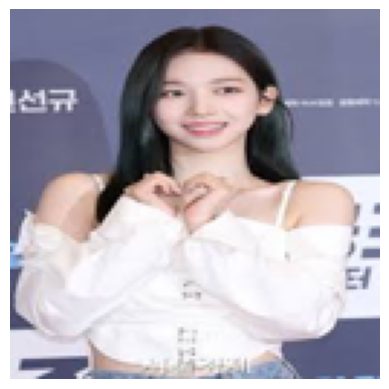

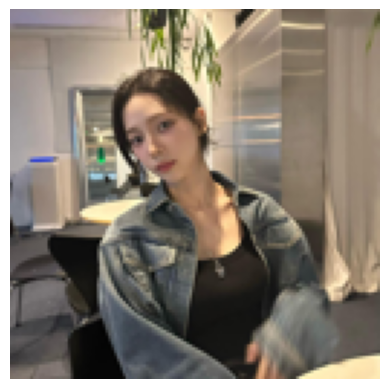

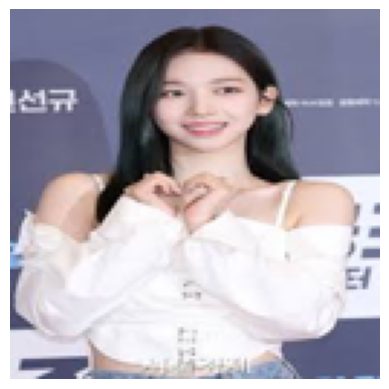

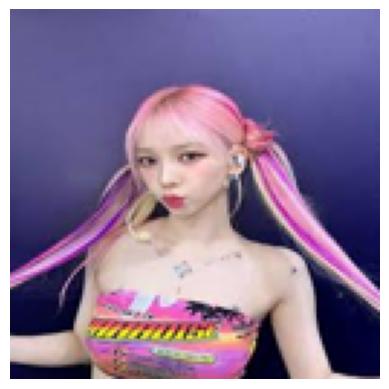

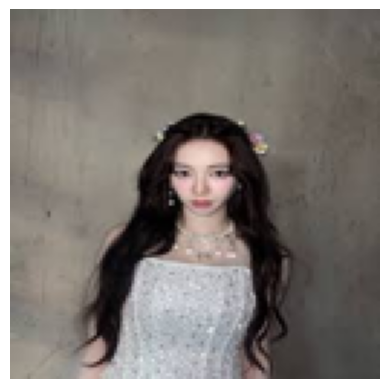

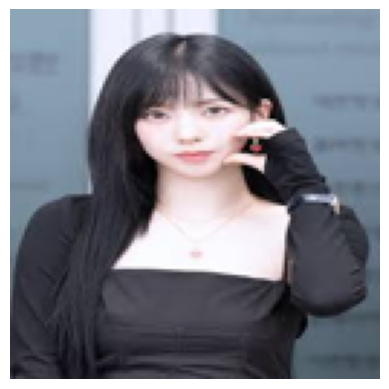

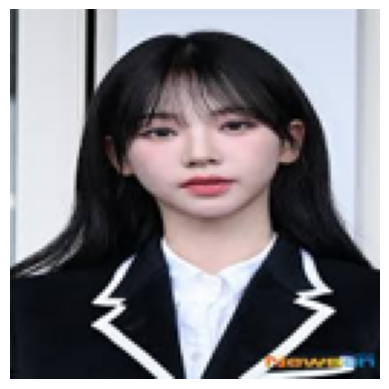

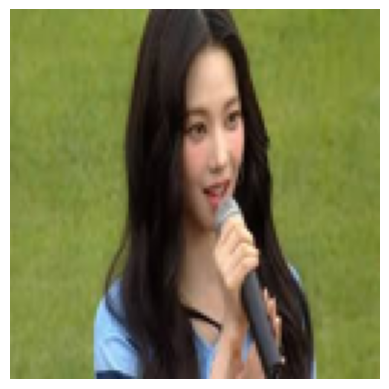

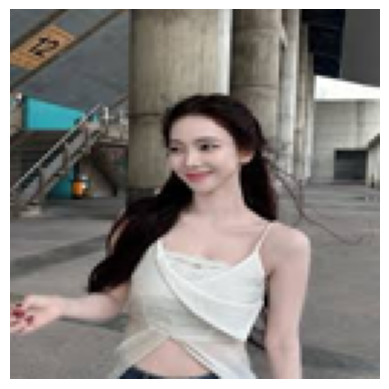

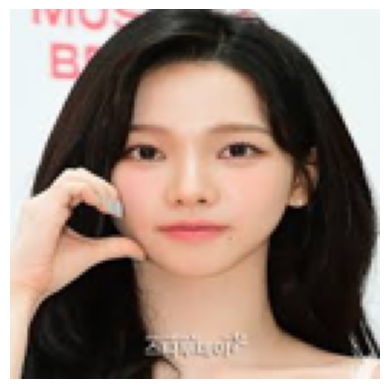

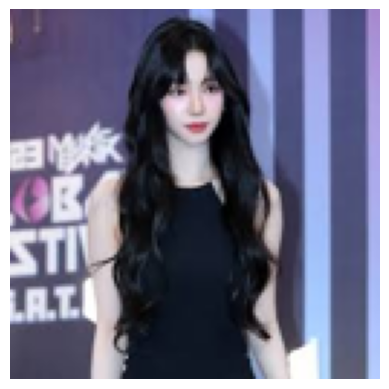

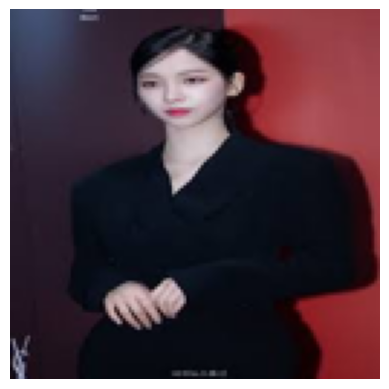

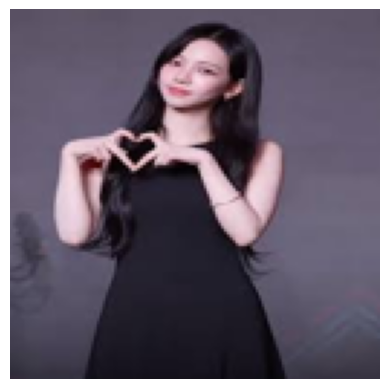

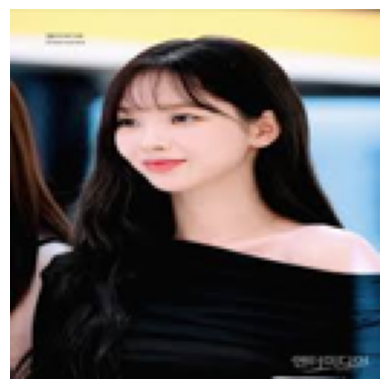

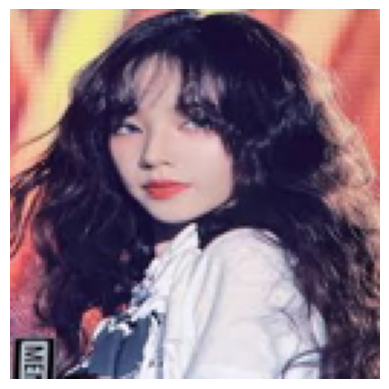

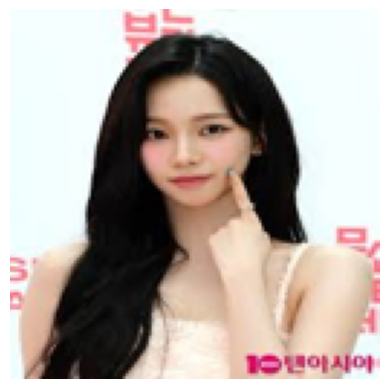

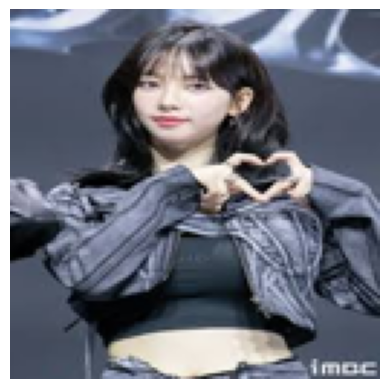

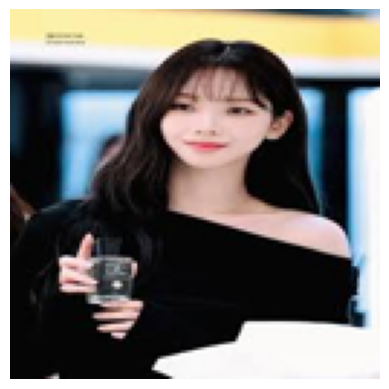

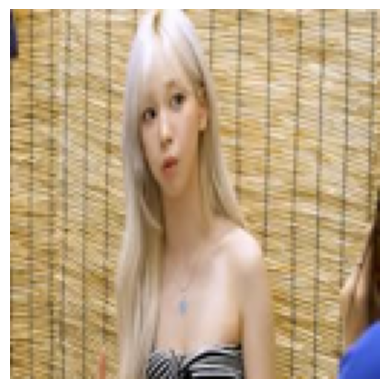

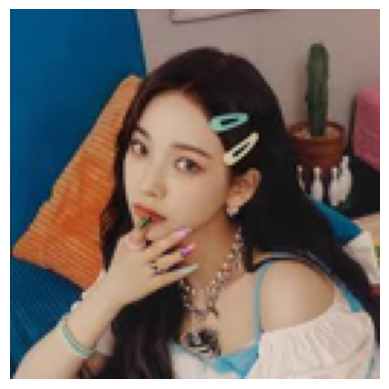

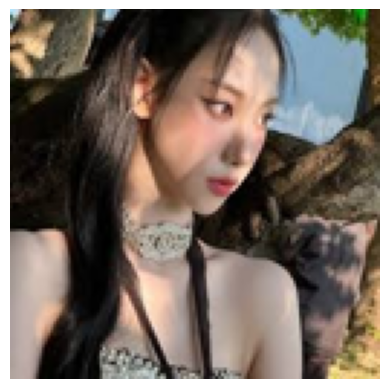

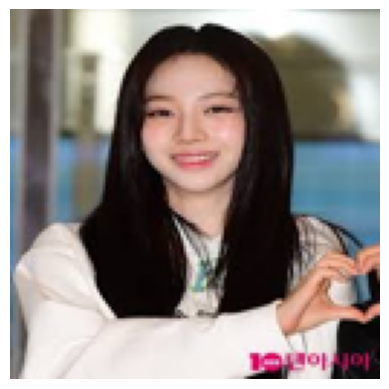

cpu
Epoch [1/10], D Loss: 6.3621, G Loss: 100.0000


KeyboardInterrupt: 

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import numpy as np
from tqdm import tqdm


# Hyperparameters
latent_dim = 100
batch_size = 46
learning_rate = 0.0002
epochs = 10


def Loader(img_paths, dim):
    images = [Image.open(img_path) for img_path in img_paths]
    images = [img.resize(dim) for img in images]
    for image in images:
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    image_arrays = [np.array(img) for img in images]

    # Normalize pixel values to [0, 1] (optional, common for ML tasks)
    image_arrays = [img.astype(np.float32) / 255.0 for img in image_arrays]

    # Convert to PyTorch tensors
    image_tensors = [torch.tensor(img).permute(2, 0, 1) for img in image_arrays] * 64  # HWC -> CHW

    # Stack tensors into a single tensor (batch of images)
    batch_tensor = torch.stack(image_tensors)

    return batch_tensor

'''
# Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
'''

dim = [128, 128]
dataset = []
names = ["카리나", ] # "winter", "wonyoung"]
for name in names:
    img_paths = [name + f"/{i}.jpeg" for i in range(batch_size)]
    data = Loader(img_paths, dim)
    dataset.append(data)  # NCHW

# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self, dim=28 * 28):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 3 * 128 * 128),
            nn.Sigmoid()  # Output in range [-1, 1]
        )

    def forward(self, z):
        y = self.model(z) * 255.0
        return y.view(z.shape[0], 3, 128, 128)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, dim=28 * 28):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3 * 128 * 128, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output in range [0, 1]
        )

    def forward(self, x):
        return self.model(x.view(x.shape[0], 3 * 128 * 128))

# Initialize models
generator = Generator(dim=128 * 128)
discriminator = Discriminator(dim=128 * 128)

# Loss and Optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
generator.to(device)
discriminator.to(device)

for epoch in range(epochs):
    for real_images in dataset:
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        for _ in range(10):
            # Train Discriminator
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_images = generator(z)
            real_output = discriminator(real_images)
            fake_output = discriminator(fake_images.detach())
            d_loss = criterion(real_output, real_labels) + criterion(fake_output, fake_labels)

            optimizer_d.zero_grad()
            d_loss.backward()
            optimizer_d.step()

        # Train Generator
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(z)
        fake_output = discriminator(fake_images)
        g_loss = criterion(fake_output, real_labels)

        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

    print(f"Epoch [{epoch+1}/{epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

# Generate and save some samples

z = torch.randn(16, latent_dim).to(device)
fake_images = generator(z).cpu().detach()
i = 0
for img in fake_images:
    pil = to_pil_image(img)
    # pil.save(f"./result/{i}.jpg")
    i += 1
    plt.imshow(pil)
    plt.axis("off")
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip install --upgrade diffusers transformers scipy


In [ ]:
import torch
from diffusers import StableDiffusionPipeline

model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"


pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)


In [ ]:
import matplotlib.pyplot as plt
prompt = "kevin levrone"
image = pipe(prompt).images[0]

plt.imshow(image)
plt.axis("off")
plt.show()

image.save(prompt+".png")
